In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imagesoasis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3419493%2F5962731%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T162740Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da149c5614eb59e543d3b247f25e111d1947afb10d6b3aaf677618b5556bcdb454df0c6a6321d95b46aa611038e91167de64924792cd5203c7aebcac1fd7c281ab6617f666bb493d1885226b107f691c372a1501b5d367082a363b9b439b2d213346703481bdd6cb15e5f122fbef5ae7216a7934f4006dfbd7382642cb42ab392daac64f9eb2f3a5650eafa37833cf0ed8375df4044a48883d3b4af0b184e67af002af1c56b909e3145f23fab2d4d53c4feb64a7c4a8b591d09ca56c8a10c0dc5a145742b1767331beefb209e025d2a8962dbaf9cacc68b41f60fdf5078628a0447f3e4c1431f82735f93f308658b6618180eefc8d5c175471cbd5cedb36b1773'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1322017985 bytes downloaded
Downloaded and uncompressed: imagesoasis
Data source import complete.


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from io import BytesIO


In [3]:
Non_Demented = []
Mild_Demented = []
Moderate_Demented = []
Very_mild_demented = []
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Non Demented'):
    for filename in filenames:
        Non_Demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Mild Dementia'):
    for filename in filenames:
        Mild_Demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Moderate Dementia'):
    for filename in filenames:
        Moderate_Demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Very mild Dementia'):
    for filename in filenames:
        Very_mild_demented.append(os.path.join(dirname, filename))


In [4]:
classes = [
    ("Non Demented", Non_Demented),
    ("Mild Dementia", Mild_Demented),
    ("Moderate Dementia", Moderate_Demented),
    ("Very mild Dementia", Very_mild_demented)
]

In [5]:
# Print the class label and the count of images for each class
for class_label, images in classes:
    print(f"{class_label}: {len(images)}")

Non Demented: 67222
Mild Dementia: 5002
Moderate Dementia: 488
Very mild Dementia: 13725


In [6]:
import random
from sklearn.model_selection import train_test_split
random.seed(42)


# Split off a test set for the moderate_demented class
Moderate_Demented_train, Moderate_Demented_test = train_test_split(
    Moderate_Demented, test_size=0.1, random_state=42
)

# Split off a test set for the mild_demented class
Mild_Demented_train, Mild_Demented_test = train_test_split(
    Mild_Demented, test_size=0.1, random_state=42
)

# Split off a test set for the very_mild_demented class
Very_mild_Demented_train, Very_mild_Demented_test = train_test_split(
    Very_mild_demented, test_size=0.1, random_state=42
)

# Split off a test set for the non_demented class
Non_Demented_train, Non_Demented_test = train_test_split(
    Non_Demented, test_size=0.1, random_state=42
)

In [7]:
classes_train = [
    ("Non Demented", Non_Demented_train),
    ("Mild Dementia", Mild_Demented_train),
    ("Moderate Dementia", Moderate_Demented_train),
    ("Very mild Dementia", Very_mild_Demented_train)
]

In [8]:
# Print the class label and the count of images for each class
for class_label, images in classes_train:
    print(f"{class_label}: {len(images)}")

Non Demented: 60499
Mild Dementia: 4501
Moderate Dementia: 439
Very mild Dementia: 12352


In [ ]:
#keeping the same
#target_samples=2500
#Moderate_Demented_samp = random.choices(Moderate_Demented_train, k=target_samples)
#Mild_Demented_samp = random.choices(Mild_Demented_train, k=target_samples)

# Undersample large classes
#Very_mild_Demented_samp = random.sample(Very_mild_Demented_train, k=target_samples)
#Non_Demented_samp = random.sample(Non_Demented_train, k=target_samples)

In [ ]:
#Moderate_Demented_samp = random.choices(Moderate_Demented_train, k=2500)


# Undersample large classes
#Mild_Demented_samp = random.sample(Mild_Demented_train, k=3000)
#Very_mild_Demented_samp = random.sample(Very_mild_Demented_train, k=3000)
#Non_Demented_samp = random.sample(Non_Demented_train, k=4000)

In [9]:
Moderate_Demented_samp = random.choices(Moderate_Demented_train, k=750)


# Undersample large classes
Mild_Demented_samp = random.sample(Mild_Demented_train, k=1000)
Very_mild_Demented_samp = random.sample(Very_mild_Demented_train, k=1000)
Non_Demented_samp = random.sample(Non_Demented_train, k=1250)

In [10]:
classes_train_samp = [
    ("Non Demented sampled", Non_Demented_samp),
    ("Mild Dementia sampled", Mild_Demented_samp),
    ("Moderate Dementia sampled", Moderate_Demented_samp),
    ("Very mild Dementia sampled", Very_mild_Demented_samp)
]
for class_label, images in classes_train_samp:
    print(f"{class_label}: {len(images)}")

Non Demented sampled: 1250
Mild Dementia sampled: 1000
Moderate Dementia sampled: 750
Very mild Dementia sampled: 1000


## Plot images

In [11]:
def plot_random_images(images, number, name):
    # Create a figure with a grid layout
    plt.figure(figsize=(10, 10))
    for i in range(number):
        # Pick a random index
        random_index = np.random.randint(len(images))
        # Get the corresponding image
        image = images[random_index]
        # Add a subplot to the grid and plot the image
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)  # Assuming grayscale images
    plt.xlabel(name)
    plt.show()

In [12]:
#plot_random_images(Moderate_Demented_samp, 5, 'Moderate_Demented')
#plot_random_images(Mild_Demented_samp, 5, 'Mild_Demented')
#plot_random_images(Very_mild_Demented_samp, 5, 'Very_mild_Demented')
#plot_random_images(Non_Demented_samp, 5, 'Non_Demented')

# Preprocessing

In [12]:
import cv2
import numpy as np
from PIL import Image

def colourscaling(images):
    colour_img = []
    for image in images:
        image = cv2.imread(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        colour_img.append(img)
    return colour_img

In [13]:
Non_Demented_samp_prep = colourscaling(Non_Demented_samp)
Very_mild_Demented_samp_prep = colourscaling(Very_mild_Demented_samp)
Mild_Demented_samp_prep = colourscaling(Mild_Demented_samp)
Moderate_Demented_samp_prep = colourscaling(Moderate_Demented_samp)

In [14]:
print(Moderate_Demented_samp_prep[1])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


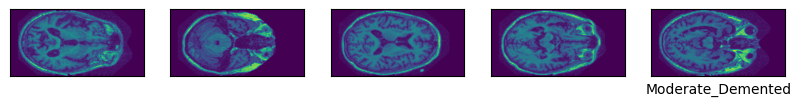

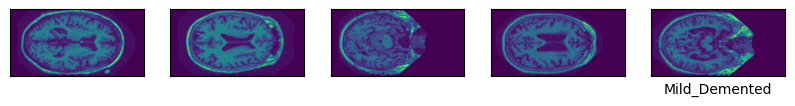

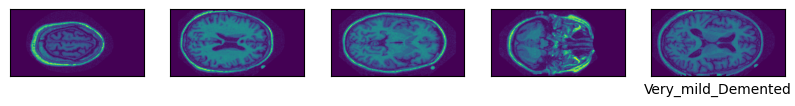

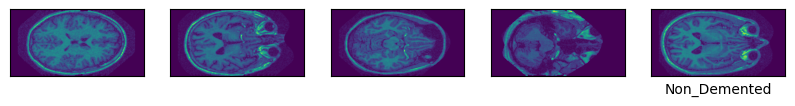

In [15]:
plot_random_images(Moderate_Demented_samp_prep, 5, 'Moderate_Demented')
plot_random_images(Mild_Demented_samp_prep, 5, 'Mild_Demented')
plot_random_images(Very_mild_Demented_samp_prep, 5, 'Very_mild_Demented')
plot_random_images(Non_Demented_samp_prep, 5, 'Non_Demented')

# Stacking and encoding:

In [16]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [17]:
data = []
label = []
for image in Non_Demented_samp_prep:
    data.append(np.array(image))
    label.append(encoder.transform([[0]]).toarray())

for image in Very_mild_Demented_samp_prep:
    data.append(np.array(image))
    label.append(encoder.transform([[1]]).toarray())

for image in Mild_Demented_samp_prep:
    data.append(np.array(image))
    label.append(encoder.transform([[2]]).toarray())

for image in Moderate_Demented_samp_prep:
    data.append(np.array(image))
    label.append(encoder.transform([[3]]).toarray())


In [18]:
data = np.array(data)
label= np.array(label)

In [19]:
data.shape

(4000, 248, 496)

In [ ]:
from sklearn.decomposition import PCA
data_flattened = np.reshape(data, (data.shape[0], -1))

# Initialize PCA with the desired variance threshold
pca = PCA(0.995)

# Fit PCA to the flattened data and transform it
data_pca = pca.fit_transform(data_flattened)

# Get the number of components required to preserve 99.5% of the variance
n_components = pca.n_components_

print("Number of components required to preserve 99.5% of the variance:", n_components)

In [ ]:
def reconstruction_errors_sample(pca, X_original, sample_size=100):
    np.random.seed(42)
    # Randomly sample the data
    sample_indices = np.random.choice(X_original.shape[0], sample_size, replace=False)
    X_sample = X_original[sample_indices]

    # Project the sampled data into PCA space
    X_pca = pca.transform(X_sample)

    # Reconstruct the sampled data
    X_reconstructed = pca.inverse_transform(X_pca)

    # Calculate the mean squared error (MSE) between original and reconstructed data
    mse = np.square(X_reconstructed - X_sample).mean(axis=-1)

    # Print reconstruction errors for each sampled image
    for i, error in enumerate(mse):
        print(f"Image {i+1}: Reconstruction Error after PCA= {error}")

    return mse, X_reconstructed

# Call the function with a sample size of 100
sample_size = 100

def reconstruction_errors_sample(pca, X_original, sample_size=100):
    np.random.seed(42)
    # Randomly sample the data
    sample_indices = np.random.choice(X_original.shape[0], sample_size, replace=False)
    X_sample = X_original[sample_indices]

    # Project the sampled data into PCA space
    X_pca = pca.transform(X_sample)

    # Reconstruct the sampled data
    X_reconstructed = pca.inverse_transform(X_pca)

    # Calculate the mean squared error (MSE) between original and reconstructed data
    mse = np.square(X_reconstructed - X_sample).mean(axis=-1)

    # Print reconstruction errors for each sampled image
    for i, error in enumerate(mse):
        print(f"Image {i+1}: Reconstruction Error after PCA= {error}")

    return sample_indices, mse, X_reconstructed

# Call the function with a sample size of 100
sample_size = 100



In [ ]:
indices, mse_sample, img_reconstructed_sample = reconstruction_errors_sample(pca, data_flattened, sample_size)

Image 1: Reconstruction Error after PCA= 0.4804758379941446
Image 2: Reconstruction Error after PCA= 0.08912512469560702
Image 3: Reconstruction Error after PCA= 2.2356121967860667
Image 4: Reconstruction Error after PCA= 0.4106252462750957
Image 5: Reconstruction Error after PCA= 14.154152063428716
Image 6: Reconstruction Error after PCA= 10.489885790660875
Image 7: Reconstruction Error after PCA= 7.8541862930983095
Image 8: Reconstruction Error after PCA= 5.623324050400177
Image 9: Reconstruction Error after PCA= 4.149409391583103
Image 10: Reconstruction Error after PCA= 2.875837522374576
Image 11: Reconstruction Error after PCA= 0.1011867118481462
Image 12: Reconstruction Error after PCA= 1.057827507378271
Image 13: Reconstruction Error after PCA= 2.9152252953158713
Image 14: Reconstruction Error after PCA= 11.471893112815346
Image 15: Reconstruction Error after PCA= 0.16408360389409377
Image 16: Reconstruction Error after PCA= 1.900467681305524
Image 17: Reconstruction Error after

In [ ]:
#Not sure this is needed
def reconstruction_errors(pca, X_original):
    # Project the original data into PCA space
    X_pca = pca.transform(X_original)

    # Reconstruct the original data
    X_reconstructed = pca.inverse_transform(X_pca)

    # Calculate the mean squared error (MSE) between original and reconstructed data
    mse = np.square(X_reconstructed - X_original).mean(axis=-1)

    return mse, X_reconstructed

# Call the function
mse, img_reconstructed = reconstruction_errors(pca, data_flattened)

In [ ]:
before_pca_labels = label.reshape((data.shape[0],4))
print(before_pca_labels.shape)

(4000, 4)


(4000, 4)
Image 1: Reconstruction Error after PCA= 0.4804758379941446
Image 2: Reconstruction Error after PCA= 0.08912512469560702
Image 3: Reconstruction Error after PCA= 2.2356121967860663
Image 4: Reconstruction Error after PCA= 0.4106252462750957
Image 5: Reconstruction Error after PCA= 14.154152063428716


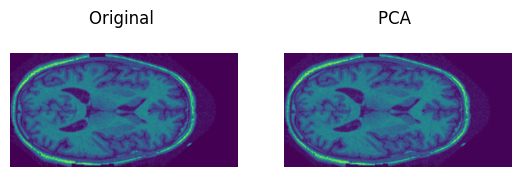

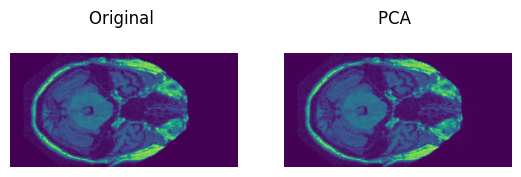

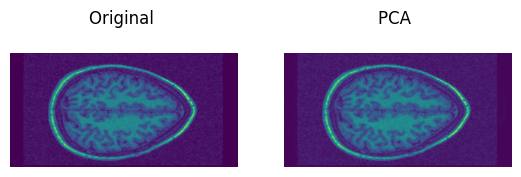

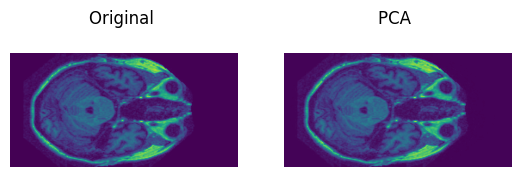

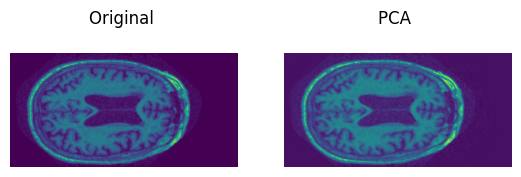

In [ ]:
labels = label.reshape((data_pca.shape[0],4))
print(labels.shape)

small_sampl = 5
indices, mse_5, img_reconstructed_5 = reconstruction_errors_sample(pca, data_flattened, small_sampl)


for i, idx in enumerate(indices):
    # Original image
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(data[idx])
    plt.title(f'Original \n', fontsize=12)
    plt.axis('off')

    reconstructed_image = img_reconstructed_5[i].reshape(248, 496)
     # PCA image
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_image)
    plt.title(f'PCA \n', fontsize=12)  # Adjust title fontsize
    plt.axis('off')

    plt.show()
    # Print reconstruction errors



Now plotting the images again

Preprocessing:
- encoding
- Colorscale
- PCA